In [1]:
# =============================================
# ✅ LOAD PROCESSED DATA (Start from here)
# =============================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("processed_reviews.csv")
df = df.drop_duplicates().reset_index(drop=True)

print("Rows Loaded:", len(df))
df.head()


Rows Loaded: 250


,S.No,Name,Date,Rating,Title,Review,lang,text_en,clean,tokens,tokens_nostop,stemmed
0,1,Anamika M. 🇮🇳,Published date02/10/25,5,Sach a good serums. . .,Sach a good serums. . .,en,Sach a good serums. . .,sach a good serums. . .,"['sach', 'a', 'good', 'serums']","['sach', 'good', 'serums']","['sach', 'good', 'serum']"
1,2,Mahima K. 🇮🇳,Published date30/09/25,5,It's really good,It's really good,en,It's really good,it s really good,"['it', 's', 'really', 'good']","['s', 'really', 'good']","['s', 'realli', 'good']"
2,3,Nancy R. 🇮🇳,Published date30/09/25,5,Great products,Great products,en,Great products,great products,"['great', 'products']","['great', 'products']","['great', 'product']"
3,4,Meghna M. 🇮🇳,Published date13/07/25,5,Its really good,I can see the difference in my skin. My skin u...,en,I can see the difference in my skin. My skin u...,i can see the difference in my skin. my skin u...,"['i', 'can', 'see', 'the', 'difference', 'in',...","['see', 'difference', 'skin', 'skin', 'used', ...","['see', 'differ', 'skin', 'skin', 'use', 'dull..."
4,5,Vaishali k. 🇮🇳,Published date26/08/25,3,My opinion,I can only say that the product is good but no...,en,I can only say that the product is good but no...,i can only say that the product is good but no...,"['i', 'can', 'only', 'say', 'that', 'the', 'pr...","['say', 'product', 'good', 'good', 'enough', '...","['say', 'product', 'good', 'good', 'enough', '..."


STEP 1 — REMOVE EMOJIS + FINAL CLEANING

In [2]:
# Regex for emojis
EMOJI_RE = re.compile(
    "[" 
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
    "]+", flags=re.UNICODE
)

def remove_emojis(s):
    return EMOJI_RE.sub("", str(s))

df["clean_noemoji"] = df["clean"].astype(str).map(remove_emojis)


STEP 2 — LEXICON-BASED SENTIMENT (VADER)

In [4]:
# Try to load VADER Sentiment
try:
    from nltk.sentiment import SentimentIntensityAnalyzer
    import nltk
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()

    def lexicon_sentiment(txt):
        score = sia.polarity_scores(str(txt))["compound"]
        if score >= 0.05:
            return "positive"
        elif score <= -0.05:
            return "negative"
        else:
            return "neutral"

except:
    print("VADER not available — using fallback lexicon rules.")

    POS_WORDS = ["good","great","excellent","amazing","love","nice","effective"]
    NEG_WORDS = ["bad","worst","waste","poor","not good","ineffective","hate"]

    def lexicon_sentiment(txt):
        t = txt.lower()
        pos = sum(w in t for w in POS_WORDS)
        neg = sum(w in t for w in NEG_WORDS)
        if pos > neg:
            return "positive"
        elif neg > pos:
            return "negative"
        else:
            return "neutral"

df["lexicon_sentiment"] = df["clean_noemoji"].map(lexicon_sentiment)
df["lexicon_sentiment"].value_counts()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...


lexicon_sentiment
positive    171
neutral      50
negative     29
Name: count, dtype: int64

In [ ]:
STEP 3 — VISUALIZE POSITIVE / NEUTRAL / NEGATIVE

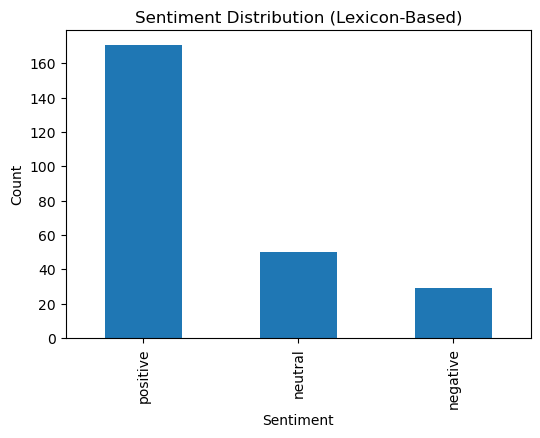

lexicon_sentiment
positive    171
neutral      50
negative     29
Name: count, dtype: int64

In [6]:
sent_counts = df["lexicon_sentiment"].value_counts()

plt.figure(figsize=(6,4))
sent_counts.plot(kind="bar")
plt.title("Sentiment Distribution (Lexicon-Based)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

sent_counts


In [ ]:
STEP 4 — ML-BASED SENTIMENT CLASSIFIER

In [7]:
# Convert rating → label
if "Rating" in df.columns:
    def rating_to_label(r):
        try:
            r = float(r)
            if r >= 4:
                return "positive"
            elif r <= 2:
                return "negative"
            else:
                return "neutral"
        except:
            return "neutral"

    df["label_ml"] = df["Rating"].map(rating_to_label)
else:
    # fallback – use lexicon sentiment
    df["label_ml"] = df["lexicon_sentiment"]


In [ ]:
STEP 5 — Train/Test Split + TF-IDF + Logistic Regression

In [8]:
# =========================================================
# STEP 0 — installs (safe for Jupyter/Anaconda)
# (Re-run only if a package is missing)
# =========================================================
import sys
pip = sys.executable

!{pip} -m pip install --quiet pandas numpy scikit-learn matplotlib seaborn
!{pip} -m pip install --quiet langdetect deep-translator afinn gensim
!{pip} -m pip install --quiet spacy
# Try to load a small, NON-Transformer spaCy model; if not available, we'll fall back later.
try:
    import spacy
    spacy.load("en_core_web_sm")
except Exception:
    try:
        !{pip} -m spacy download en_core_web_sm
    except Exception as e:
        print("spaCy model download failed; POS/NER will fall back to no-op.")


In [9]:
# =========================================================
# STEP 1 — load data
# =========================================================
import os, re, warnings, math, json, random
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# >>>> change these if needed <<<<
INPUT_CSV  = "processed_reviews.csv"                      # your processed file
FALLBACK   = "minimalist_reviews_with_ratings.csv"        # in case you want to use the scraper output
TEXT_COL   = "Review"                                     # main text column
RATING_COL = "Rating"                                     # numeric rating 1..5 if present

path = INPUT_CSV if os.path.exists(INPUT_CSV) else FALLBACK
assert os.path.exists(path), f"CSV not found at {path}"

# robust read (skip broken lines, keep encoding safe)
df = pd.read_csv(path, encoding="utf-8", on_bad_lines="skip")
print("Loaded:", path, "| rows:", len(df), "| cols:", list(df.columns))

# Keep only the columns we need, if present
keep_cols = [c for c in ["S.No","Name","Date",RATING_COL,"Title",TEXT_COL] if c in df.columns]
if not keep_cols:
    # if Review column is missing, try common alternatives
    for alt in ["review","text","comment","body"]:
        if alt in df.columns:
            TEXT_COL = alt
            keep_cols = [c for c in ["S.No","Name","Date",RATING_COL,"Title",TEXT_COL] if c in df.columns]
            break
assert TEXT_COL in df.columns, f"Could not find a text column. Have: {df.columns.tolist()}"

df = df[keep_cols].copy()
df = df.dropna(subset=[TEXT_COL])
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df = df[df[TEXT_COL].str.len() > 0].reset_index(drop=True)
print("Rows after basic pruning:", len(df))
df.head(3)


Loaded: processed_reviews.csv | rows: 250 | cols: ['S.No', 'Name', 'Date', 'Rating', 'Title', 'Review', 'lang', 'text_en', 'clean', 'tokens', 'tokens_nostop', 'stemmed']
Rows after basic pruning: 250


,S.No,Name,Date,Rating,Title,Review
0,1,Anamika M. 🇮🇳,Published date02/10/25,5,Sach a good serums. . .,Sach a good serums. . .
1,2,Mahima K. 🇮🇳,Published date30/09/25,5,It's really good,It's really good
2,3,Nancy R. 🇮🇳,Published date30/09/25,5,Great products,Great products


In [ ]:
# =========================================================
# STEP 2 — Language Identification + non-Transformer Translation
# =========================================================
from langdetect import detect, DetectorFactory
from deep_translator import GoogleTranslator
DetectorFactory.seed = 42

def safe_lang(s: str) -> str:
    try:
        return detect(s) if isinstance(s, str) and s.strip() else "unknown"
    except Exception:
        return "unknown"

df["lang"] = df[TEXT_COL].map(safe_lang)

def translate_to_en(text, src):
    # only translate if clearly non-English
    if not isinstance(text, str) or not text.strip():
        return text, False, None
    if src in ("en","unknown"):
        return text, False, None
    try:
        t = GoogleTranslator(source=src, target="en").translate(text)
        return t, True, None
    except Exception as e:
        # keep original if translation fails (offline / blocked)
        return text, False, str(e)

trans_out = df.apply(lambda r: translate_to_en(r[TEXT_COL], r["lang"]), axis=1)
df["text_en"]        = [t[0] for t in trans_out]
df["translated"]     = [t[1] for t in trans_out]
df["translate_error"]= [t[2] for t in trans_out]

print("Unique languages detected:", df["lang"].value_counts(dropna=False).to_dict())
print("Translated rows:", int(df["translated"].sum()))
df.head(3)


In [ ]:
# =========================================================
# STEP 3 — Cleaning & Normalization (emoji removal, html/url strip, lowercase, tokenization, stopwords, stemming)
# (All classic, non-Transformer)
# =========================================================
# Minimal, local stopword list (avoid NLTK download issues)
STOPWORDS = set("""
a an the and or but if while is are was were be been being am to for from in on at by of with as into through during
about over under again further then once here there when where why how all any both each few more most other some such
no nor not only own same so than too very can will just should now i me my you your he him his she her it its we our they
them what which who whom this that these those do does did doing don t haven hasn won wouldn could would should
""".split())

# emoji removal (we remove emojis per your requirement)
EMOJI_RE = re.compile("[" 
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)

def clean_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.replace("\xa0", " ").replace("\u200b"," ")
    s = re.sub(r"<[^>]+>", " ", s)                 # HTML tags
    s = re.sub(r"http\S+|www\.\S+", " ", s)        # URLs
    s = EMOJI_RE.sub(" ", s)                       # emojis
    s = re.sub(r"[^A-Za-z0-9\s\.\,\!\?\:\;\-\']"," ", s)  # non-text
    s = re.sub(r"\s+"," ", s).strip()
    return s

df["text_en"] = df["text_en"].astype(str).map(clean_text)
df = df.drop_duplicates(subset=["text_en"]).reset_index(drop=True)

# tokenize -> remove stopwords -> simple Porter stem (no corpus needed)
try:
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
except Exception:
    stemmer = None

TOKEN_RE = re.compile(r"[a-zA-Z]+(?:'[a-z]+)?")
def tokenize_basic(s: str):
    return TOKEN_RE.findall(s.lower())

def remove_stop(tokens):
    return [t for t in tokens if t not in STOPWORDS and len(t) > 1]

def stem_tokens(tokens):
    if stemmer is None:
        return tokens
    return [stemmer.stem(t) for t in tokens]

df["tokens"] = df["text_en"].map(tokenize_basic).map(remove_stop).map(stem_tokens)
df["clean"]  = df["tokens"].map(lambda ts: " ".join(ts))

print("Rows after cleaning & dedup:", len(df))
df[[TEXT_COL,"lang","translated","text_en","clean"]].head(3)


In [ ]:
# =========================================================
# STEP 4 — POS Tagging & NER (non-Transformer spaCy if available)
# =========================================================
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")  # statistical (non-Transformer)
    SPACY_OK = True
except Exception:
    try:
        import spacy
        nlp = spacy.blank("en")  # tokenizer only
        SPACY_OK = False
    except Exception:
        nlp, SPACY_OK = None, False

pos_counts = {}
ner_counts = {}

if SPACY_OK:
    # NOTE: avoid running this on huge data in one cell; this is fine for ~few thousands
    docs = list(nlp.pipe(df["text_en"].tolist(), batch_size=128, disable=[]))
    df["pos_seq"] = [[(t.text, t.pos_) for t in d] for d in docs]
    df["entities"] = [[(e.text, e.label_) for e in d.ents] for d in docs]

    # POS distribution (top adjectives/verbs)
    all_pos = []
    for d in docs:
        all_pos.extend([t.pos_ for t in d])
    pos_counts = pd.Series(all_pos).value_counts().to_dict()

    # NER distribution
    all_ents = []
    for d in docs:
        all_ents.extend([e.label_ for e in d.ents])
    ner_counts = pd.Series(all_ents).value_counts().to_dict()

    print("POS counts (top 10):", dict(list(pos_counts.items())[:10]))
    print("NER counts (top 10):", dict(list(ner_counts.items())[:10]))
else:
    df["pos_seq"]  = [[] for _ in range(len(df))]
    df["entities"] = [[] for _ in range(len(df))]
    print("spaCy model unavailable — skipping POS/NER (pipeline continues).")


In [ ]:
# =========================================================
# STEP 5 — Lexicon Sentiment (AFINN) + label by rating (if available)
#  - Visualize + / - / neutral counts
# =========================================================
from afinn import Afinn
af = Afinn()

def afinn_polarity(s: str) -> int:
    score = af.score(s)
    # map continuous score to -1/0/1
    return -1 if score < -0.5 else (1 if score > 0.5 else 0)

df["lex_score"] = df["text_en"].map(af.score)
df["lex_label"] = df["text_en"].map(afinn_polarity)   # -1 neg, 0 neutral, 1 pos

# If you have star RATING, derive a supervised label
if RATING_COL in df.columns:
    def label_from_stars(x):
        try:
            x = float(x)
        except Exception:
            return np.nan
        if x >= 4: return 1
        if x <= 2: return -1
        return 0
    df["label_sup"] = df[RATING_COL].map(label_from_stars)
else:
    df["label_sup"] = np.nan

# Visualize counts (lexicon)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

counts = df["lex_label"].map({-1:"Negative",0:"Neutral",1:"Positive"}).value_counts().reindex(["Positive","Neutral","Negative"]).fillna(0)
plt.figure(figsize=(5,3))
counts.plot(kind="bar")
plt.title("Lexicon Sentiment Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

counts.to_dict()


In [ ]:
# =========================================================
# STEP 6 — Train/Test split + TF-IDF + Logistic Regression (supervised)
#     - uses 'label_sup' from star ratings as ground truth
# =========================================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keep only rows with a supervised label
sup = df.dropna(subset=["label_sup"]).copy()
sup["label_sup"] = sup["label_sup"].astype(int)

# If your dataset is small, this still works; otherwise raise if too tiny
assert len(sup) > 20, f"Need more labeled rows from ratings; got {len(sup)}."

X_train, X_test, y_train, y_test = train_test_split(
    sup["clean"], sup["label_sup"], test_size=0.2, random_state=42, stratify=sup["label_sup"]
)

tfidf = TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1,2))
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

clf = LogisticRegression(max_iter=200, n_jobs=None)
clf.fit(Xtr, y_train)

pred = clf.predict(Xte)
proba = clf.predict_proba(Xte)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

# attach supervised prediction back to df
df["sup_pred"] = np.nan
df.loc[sup.index, "sup_pred"] = clf.predict(tfidf.transform(sup["clean"]))


In [ ]:
# =========================================================
# STEP 7 — Topic Modeling (LSA over TF-IDF)
# =========================================================
from sklearn.decomposition import TruncatedSVD

# Fit TF-IDF on ALL cleaned text for topics
tfidf_all = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2))
X_all = tfidf_all.fit_transform(df["clean"])
n_topics = min(5, max(2, X_all.shape[0]//200)) or 2  # between 2 and 5

svd = TruncatedSVD(n_components=n_topics, random_state=42)
X_topics = svd.fit_transform(X_all)

def top_terms(component, feature_names, k=10):
    idx = np.argsort(component)[::-1][:k]
    return [feature_names[i] for i in idx]

feat_names = np.array(tfidf_all.get_feature_names_out())
topics = []
for i, comp in enumerate(svd.components_):
    topics.append((i+1, top_terms(comp, feat_names, k=10)))
topics


In [ ]:
# =========================================================
# STEP 8 — Vector semantics & similarity (Word2Vec + cosine sim on averaged embeddings)
# =========================================================
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Train small Word2Vec on our tokens (CBOW)
sentences = df["tokens"].tolist()
w2v = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=2, sg=0, epochs=20)

def sent_embed(tokens):
    vecs = [w2v.wv[t] for t in tokens if t in w2v.wv]
    if not vecs:
        return np.zeros(w2v.vector_size)
    return np.mean(vecs, axis=0)

embeds = np.vstack([sent_embed(ts) for ts in df["tokens"]])
# Similarity matrix (can be large; use with care on huge data)
sim_matrix = cosine_similarity(embeds)

# Example: find top-5 most similar reviews to review 0
if len(df) >= 6:
    sims0 = sim_matrix[0]
    top5 = np.argsort(sims0)[::-1][1:6]
    print("Top-5 similar to #0:", top5.tolist())


In [ ]:
# =========================================================
# STEP 9 — Similarity-based Summarization (cluster + representatives)
# =========================================================
from sklearn.cluster import AgglomerativeClustering

# Use TF-IDF vectors for clustering (safer than raw embeddings if many zero vectors)
X = X_all
# some rows can become zero vectors; we handle them by small epsilon
row_norms = np.asarray(X.power(2).sum(axis=1)).ravel()
nonzero_idx = np.where(row_norms > 0)[0]
X_nz = X[nonzero_idx]

n_clusters = min(5, max(2, len(nonzero_idx)//100)) or 2
# Newer sklearn uses 'metric' instead of 'affinity'
clust = AgglomerativeClustering(n_clusters=n_clusters, linkage="average", metric="cosine")
labels = clust.fit_predict(X_nz.toarray())  # average-linkage expects dense; for big data, switch to MiniBatchKMeans

# Representative review per cluster: closest to cluster centroid (using cosine with cluster mean)
from sklearn.preprocessing import normalize
Xn = normalize(X_nz)
reps = []
for c in range(n_clusters):
    idxs = nonzero_idx[labels==c]
    if len(idxs)==0: continue
    block = Xn[labels==c]
    centroid = block.mean(axis=0)
    sims = block @ centroid.T
    rep_local = idxs[int(np.argmax(sims))]
    reps.append(rep_local)

print("Representative review indices:", reps)
for rid in reps:
    print(f"\n[Rep #{rid}] {df.loc[rid, TEXT_COL]}")


In [ ]:
# =========================================================
# STEP 10 — Quick Q&A synthesis from the analysis
# (Simple heuristic using adjectives/nouns + sentiment & topics)
# =========================================================
def sentiment_ratio(series):
    total = len(series)
    pos = (series==1).sum()
    neg = (series==-1).sum()
    neu = (series==0).sum()
    return {"pos_pct": round(100*pos/total,1) if total else 0,
            "neg_pct": round(100*neg/total,1) if total else 0,
            "neu_pct": round(100*neu/total,1) if total else 0}

summary_lex = sentiment_ratio(df["lex_label"])
summary_sup = sentiment_ratio(df["label_sup"].dropna().astype(int)) if "label_sup" in df else {}

print("Q1: Overall sentiment from reviews?")
print(f"A1: Lexicon approx — +:{summary_lex['pos_pct']}% / 0:{summary_lex['neu_pct']}% / -:{summary_lex['neg_pct']}%", 
      "| Supervised (ratings-based) approx —", summary_sup if summary_sup else "n/a")

print("\nQ2: What are the main topics?")
for i, terms in topics:
    print(f"A2.{i}: {'; '.join(terms[:8])}")

print("\nQ3: Are there common complaints?")
# crude: take most frequent words from negative lexicon reviews
neg_words = []
for tokens, lbl in zip(df["tokens"], df["lex_label"]):
    if lbl == -1: neg_words.extend(tokens)
pd.Series(neg_words).value_counts().head(10)


In [ ]:
# =========================================================
# STEP 11 — Save final enriched CSV and (optionally) offer a download link
# =========================================================
FINAL_CSV = "final_reviews_enriched.csv"
out_cols = [c for c in [
    "S.No","Name","Date",RATING_COL,"Title",
    TEXT_COL,"lang","translated","translate_error",
    "text_en","clean","lex_score","lex_label","label_sup","sup_pred"
] if c in df.columns]

df[out_cols].to_csv(FINAL_CSV, index=False, encoding="utf-8-sig")
print("Saved:", FINAL_CSV, "| rows:", len(df))

# If you want a clickable link inside Jupyter:
try:
    from IPython.display import FileLink, display
    display(FileLink(FINAL_CSV))
except Exception:
    pass
